[来源：一篇文章带你搞懂使用PID](https://rymcu.com/article/1195)

# 比例控制算法

我们先说 PID 中最简单的比例控制，抛开其他两个不谈，还是用一个经典的例子吧。假设我有一个水缸，最终的控制目的是要保证水缸里的水位永远的维持在 1 米的高度。假设初始时刻，水缸里的水位是 0.2 米，那么当前时刻的水位和目标水位之间是存在一个误差的 error，且 error 为 0.8.这个时候，假设旁边站着一个人，这个人通过往缸里加水的方式来控制水位。如果单纯的用比例控制算法(kp)，就是指加入的水量 u 和误差 error 是成正比的。即 u = kp * error

假设现在 kp = 0.5，则有:

t=1 时（表示第 1 次加水，也就是第一次对系统施加控制），那么 u=0.5x0.8=0.4，所以这一次加入的水量会使水位在 0.2 的基础上上升 0.4，达到 0.6.

t=2 时刻（第 2 次施加控制），当前水位是 0.6，所以 error 是 0.4。u=0.5x0.4=0.2，会使水位再次上升 0.2，达到 0.8。

t=3...

....

t=n...

可以看到，最终水位会达到我们需要的 1 米。

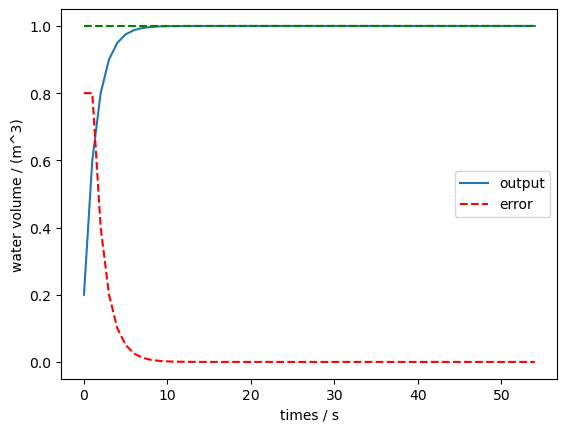

[0.2, 0.6000000000000001, 0.8, 0.9, 0.95, 0.975, 0.9875, 0.99375, 0.996875, 0.9984375, 0.99921875, 0.999609375, 0.9998046875, 0.99990234375, 0.999951171875, 0.9999755859375, 0.99998779296875, 0.999993896484375, 0.9999969482421875, 0.9999984741210938, 0.9999992370605468, 0.9999996185302734, 0.9999998092651368, 0.9999999046325684, 0.9999999523162841, 0.9999999761581421, 0.9999999880790711, 0.9999999940395355, 0.9999999970197677, 0.9999999985098839, 0.999999999254942, 0.999999999627471, 0.9999999998137354, 0.9999999999068677, 0.9999999999534339, 0.999999999976717, 0.9999999999883584, 0.9999999999941792, 0.9999999999970897, 0.9999999999985448, 0.9999999999992724, 0.9999999999996362, 0.9999999999998181, 0.9999999999999091, 0.9999999999999545, 0.9999999999999772, 0.9999999999999887, 0.9999999999999943, 0.9999999999999971, 0.9999999999999986, 0.9999999999999993, 0.9999999999999997, 0.9999999999999998, 0.9999999999999999, 1.0]
[info] iterate times:  53


In [1]:
import matplotlib.pyplot as plt

class ApplicationWithKp:
    def __init__(self, ex=1, current=0.2, kp=0.5):
        self.ex = ex
        self.current = current
        self.kp = kp
        self.error = self.ex - self.current
        self.iterate_times = 0

        self.output_list = [self.current]
        self.error_list = [self.error]

    def run(self):
        self.iterate(100)
        self.plot()
        print(self.output_list)
        print("[info] iterate times: ", self.iterate_times)

    def iterate(self, epoch):
        """ iterate to update current, error """
        for i in range(epoch):
            # 加水量u
            u = self.kp * self.error
            self.current += u
            self.output_list.append(self.current)
            self.error_list.append(self.error)
            self.error = self.ex - self.current
            if self.current >= self.ex:
                self.iterate_times = i
                return
            self.iterate_times = epoch

    def plot(self):
        l1, = plt.plot(list(range(len(self.output_list))), self.output_list, label='output')
        l2, = plt.plot(list(range(len(self.error_list))), self.error_list, label='error', linestyle='--', color='r')
        l3 = plt.plot(list(range(len(self.output_list))), [1] * len(self.output_list), linestyle='--', color='g'  )
        plt.xlabel('times / s')
        plt.ylabel('water volume / (m^3)')
        plt.legend(handles=[l1, l2],
                   labels = ['output', 'error'])
        plt.show()

app = ApplicationWithKp()
app.run()

可以看到，当 kp=0.5 时，需要迭代 53 次才能形成稳态，接下来我们把 kp 设为 0.9，看看要迭代多少次。

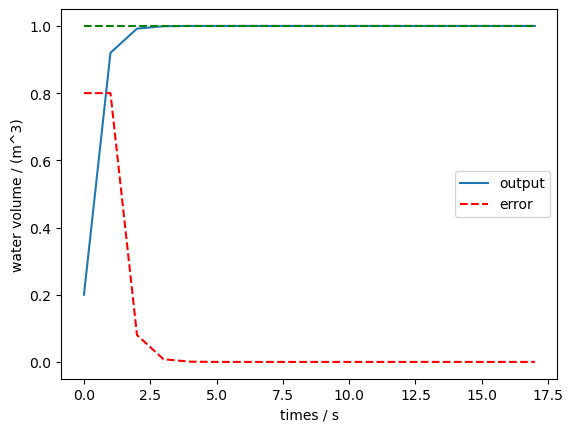

[0.2, 0.9200000000000002, 0.992, 0.9992, 0.99992, 0.999992, 0.9999992, 0.99999992, 0.999999992, 0.9999999992, 0.99999999992, 0.999999999992, 0.9999999999992, 0.99999999999992, 0.999999999999992, 0.9999999999999992, 0.9999999999999999, 1.0]
[info] iterate times:  16


In [2]:
app_2 = ApplicationWithKp(kp=0.9)
app_2.run()

可以看到，kp=0.9 时迭代 16 次就收敛了，可以看出 kp 起着一个放大控制作用。

像上述的例子，根据 kp 取值不同，系统最后都会达到 1 米，只不过 kp 大了到达的快，kp 小了到达的慢一些。不会有稳态误差。但是，考虑另外一种情况，假设这个水缸在加水的过程中，存在漏水的情况，假设每次加水的过程，都会漏掉 0.1 米高度的水。仍然假设 kp 取 0.5，那么会存在着某种情况，假设经过几次加水，水缸中的水位到 0.8 时，水位将不会再变换。因为水位为 0.8，则误差 error=0.2. 所以每次往水缸中加水的量为 u=0.50.2=0.1.同时，每次加水，缸里又会流出去 0.1 米的水。加入的水和流出的水相抵消，水位将不再变化。

我们仅需要把刚才 iterate 函数中 current += u 的代码改成 current += u - 0.1 ，就能得到以下结果。

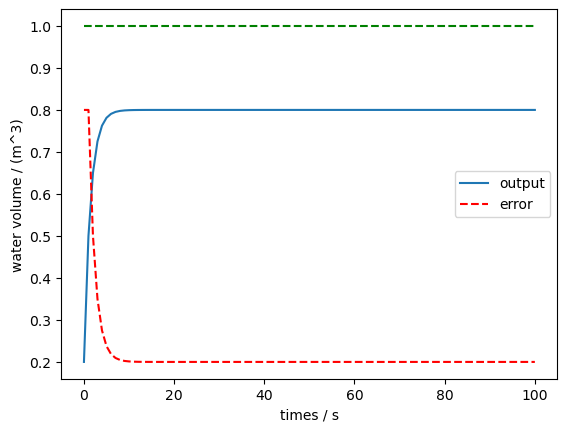

[0.2, 0.5, 0.65, 0.725, 0.7625, 0.78125, 0.790625, 0.7953125, 0.79765625, 0.798828125, 0.7994140625, 0.79970703125, 0.799853515625, 0.7999267578125, 0.79996337890625, 0.799981689453125, 0.7999908447265625, 0.7999954223632812, 0.7999977111816406, 0.7999988555908203, 0.7999994277954101, 0.7999997138977051, 0.7999998569488526, 0.7999999284744262, 0.7999999642372131, 0.7999999821186066, 0.7999999910593033, 0.7999999955296516, 0.7999999977648258, 0.7999999988824129, 0.7999999994412065, 0.7999999997206032, 0.7999999998603016, 0.7999999999301508, 0.7999999999650754, 0.7999999999825377, 0.7999999999912688, 0.7999999999956344, 0.7999999999978172, 0.7999999999989086, 0.7999999999994543, 0.7999999999997272, 0.7999999999998636, 0.7999999999999318, 0.7999999999999658, 0.799999999999983, 0.7999999999999915, 0.7999999999999957, 0.7999999999999978, 0.7999999999999989, 0.7999999999999995, 0.7999999999999997, 0.7999999999999998, 0.7999999999999999, 0.7999999999999999, 0.7999999999999999, 0.7999999999999

In [3]:
import matplotlib.pyplot as plt

class ApplicationWithKp:
    def __init__(self, ex=1, current=0.2, kp=0.5):
        self.ex = ex
        self.current = current
        self.kp = kp
        self.error = self.ex - self.current
        self.iterate_times = 0

        self.output_list = [self.current]
        self.error_list = [self.error]

    def run(self):
        self.iterate(100)
        self.plot()
        print(self.output_list)
        print("[info] iterate times: ", self.iterate_times)

    def iterate(self, epoch):
        """ iterate to update current, error """
        for i in range(epoch):
            # 加水量u
            u = self.kp * self.error
            self.current += u - 0.1
            self.output_list.append(self.current)
            self.error_list.append(self.error)
            self.error = self.ex - self.current
            if self.current >= self.ex:
                self.iterate_times = i
                return
            self.iterate_times = epoch

    def plot(self):
        l1, = plt.plot(list(range(len(self.output_list))), self.output_list, label='output')
        l2, = plt.plot(list(range(len(self.error_list))), self.error_list, label='error', linestyle='--', color='r')
        l3 = plt.plot(list(range(len(self.output_list))), [1] * len(self.output_list), linestyle='--', color='g'  )
        plt.xlabel('times / s')
        plt.ylabel('water volume / (m^3)')
        plt.legend(handles=[l1, l2],
                   labels = ['output', 'error'])
        plt.show()

app = ApplicationWithKp()
app.run()

也就是说，我的目标是 1 米，但是最后系统达到 0.8 米的水位就不再变化了，且系统已经达到稳定。由此产生的误差就是稳态误差了。

在实际情况中，这种类似水缸漏水的情况往往更加常见，比如控制汽车运动，摩擦阻力就相当于是“漏水”，控制机械臂、无人机的飞行，各类阻力和消耗都可以理解为本例中的“漏水”。所以，单独的比例控制，在很多时候并不能满足要求。

# 积分控制算法
通过上面的例子我们可以发现，如果仅仅使用比例控制算法，就会存在稳态误差的问题。因此，当前我们再引入一个分量，该分量与误差的积分是正比关系，加入积分控制，公式变为:u = kp * error + ki * ∫error

还是用上面的例子来说明，第一次的误差 error 是 0.8，第二次的误差是 0.4，至此，误差的积分（离散情况下积分其实就是做累加），∫error=0.8+0.4=1.2. 这个时候的控制量，除了比例的那一部分，还有一部分就是一个系数 ki 乘以这个积分项。由于这个积分项会将前面若干次的误差进行累计，所以可以很好的消除稳态误差（假设在仅有比例项的情况下，系统卡在稳态误差了，即上例中的 0.8，由于加入了积分项的存在，会让输入增大，从而使得水缸的水位可以大于 0.8，渐渐到达目标的 1.0.）这就是积分项的作用。

KI 的 Python 实现，我们只需要在刚才 ApplicationWithKp 类的基础上稍作修改，就可以得到 ApplicationWithKpKi 的实现，代码如下：

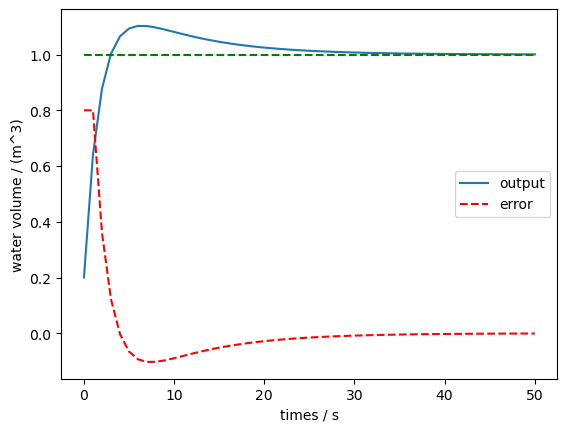

[0.2, 0.6400000000000001, 0.8780000000000001, 1.0031, 1.065495, 1.09341775, 1.1027082375, 1.1022180693749999, 1.09686208184375, 1.0893409839859376, 1.0811133858577344, 1.072943917500746, 1.0652119874472146, 1.058085423048088, 1.0516178696961205, 1.0458031995353307, 1.0406057044781694, 1.0359766717256802, 1.0318633217631514, 1.0282134806937295, 1.0249778861243322, 1.022111194533417, 1.0195722890112884, 1.0173242217996596, 1.0153339771038623, 1.0135721559007707, 1.0120126375041862, 1.0106322464306847, 1.0094104385723996, 1.0083290127146372, 1.007371849150024, 1.0065246749102164, 1.0057748540448017, 1.0051112009098542, 1.0045238142968878, 1.0040039302755601, 1.0035437917511183, 1.0031365329013415, 1.002776076831386, 1.002457044954839, 1.0021746767688235, 1.0019247588373745, 1.0017035619297814, 1.0015077853794958, 1.0013345078353781, 1.0011811436715505, 1.001045404406059, 1.0009252645530105, 1.0008189313988356, 1.0007248182518065, 1.0006415207657016]
[info] iterate times:  50


In [4]:
import matplotlib.pyplot as plt

class ApplicationWithKpKi:
    def __init__(self, ex=1, current=0.2, kp=0.5, ki=0.05):
        self.ex = ex
        self.current = current
        self.kp = kp
        self.ki = ki
        self.error = self.ex - self.current
        self.error_acc = self.error # error accumulation
        self.iterate_times = 0

        self.output_list = [self.current]
        self.error_list = [self.error]

    def run(self):
        self.iterate(50)
        self.plot()
        print(self.output_list)
        print("[info] iterate times: ", self.iterate_times)

    def iterate(self, epoch):
        """ iterate to update current, error """
        for i in range(epoch):
            # 加水量u
            u = self.kp * self.error + self.ki * self.error_acc
            self.current += u
            self.output_list.append(self.current)
            self.error_list.append(self.error)
            self.error = self.ex - self.current
            self.error_acc += self.error
            # if self.current >= self.ex:
            #     self.iterate_times = i
            #     return
            self.iterate_times = epoch

    def plot(self):
        l1, = plt.plot(list(range(len(self.output_list))), self.output_list, label='output')
        l2, = plt.plot(list(range(len(self.error_list))), self.error_list, label='error', linestyle='--', color='r')
        l3 = plt.plot(list(range(len(self.output_list))), [1] * len(self.output_list), linestyle='--', color='g'  )
        plt.xlabel('times / s')
        plt.ylabel('water volume / (m^3)')
        plt.legend(handles=[l1, l2],
                   labels = ['output', 'error'])
        plt.show()

if __name__ == '__main__':
    app = ApplicationWithKpKi(kp=0.5, ki=0.05)
    app.run()

我们可以看到，事实上，因为 error 的积累导致的超调，即在装水的过程中装了比 1L 还多的水！当然，在当前这个例子中，水桶中的水大于 1L 的情况是不可能存在的，但是在其他场景下允许该中情况的出现，因此，关于 Ki 我们就需要调整到一个合适的值。

# 微分控制算法
换一个另外的例子，考虑刹车情况。平稳的驾驶车辆，当发现前面有红灯时，为了使得行车平稳，基本上提前几十米就放松油门并踩刹车了。当车辆离停车线非常近的时候，则使劲踩刹车，使车辆停下来。整个过程可以看做一个加入微分的控制策略。

微分，说白了在离散情况下，就是 error 的差值，就是 t 时刻和 t-1 时刻 error 的差，即 u=kd*（error（t）-error（t-1）），其中的 kd 是一个系数项。可以看到，在刹车过程中，因为 error 是越来越小的，所以这个微分控制项一定是负数，在控制中加入一个负数项，他存在的作用就是为了防止汽车由于刹车不及时而闯过了线。从常识上可以理解，越是靠近停车线，越是应该注意踩刹车，不能让车过线，所以这个微分项的作用，就可以理解为刹车，当车离停车线很近并且车速还很快时，这个微分项的绝对值（实际上是一个负数）就会很大，从而表示应该用力踩刹车才能让车停下来。
切换到上面给水缸加水的例子，就是当发现水缸里的水快要接近 1 的时候，加入微分项，可以防止给水缸里的水加到超过 1 米的高度，说白了就是减少控制过程中的震荡。

有前面两次的代码迭代，我们最后要实现 kd 的累加也很简单，只需要再之前的代码的基础上记录下两次 error 的差值就可以了，即记录下 e(t) - e(t-1)

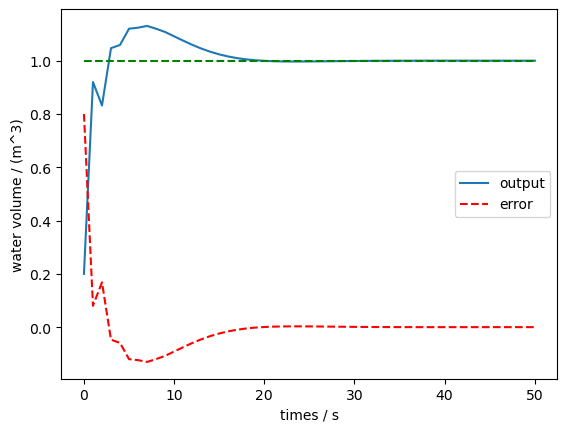

[0.2, 0.9199999999999999, 0.832, 1.0472, 1.05912, 1.120152, 1.1239192, 1.13059032, 1.119995672, 1.1078785112, 1.09148883352, 1.075426866392, 1.0597548830232, 1.04582640790872, 1.033756477084312, 1.0237883006766553, 1.015794856080136, 1.0096262286305215, 1.0050318468985906, 1.0017591976274611, 0.9995504334909098, 0.9981718425331697, 0.9974163108473393, 0.9971099961381172, 0.997111074076712, 0.9973082878439932, 0.9976172251946285, 0.9979764542754771, 0.9983433358692897, 0.9986901473253778, 0.9990005593622014, 0.9992666292701724, 0.9994863039357965, 0.999661429447733, 0.9997962140050342, 0.9998960871695719, 0.9999668884527126, 1.0000143218134308, 1.0000436166891735, 1.0000593440036203, 1.0000653435288704, 1.0000647272753673, 1.0000599311547052, 1.0000527939390513, 1.0000446482658167, 1.000036413139892, 1.0000286810987473, 1.0000217960428663, 1.00001591981506, 1.0000110870712284, 1.0000072489469976]
[info] iterate times:  50


In [5]:
import matplotlib.pyplot as plt

class ApplicationWithKpKiKd:
    def __init__(self, ex=1, current=0.2, kp=0.5, ki=0.05, kd=0.1):
        self.ex = ex
        self.current = current
        self.kp = kp
        self.ki = ki
        self.kd = kd
        self.error = self.ex - self.current
        self.error_acc = self.error # error accumulation
        self.delta_error = self.error # d_e = e(t) - e(t-1)
        self.iterate_times = 0

        self.output_list = [self.current]
        self.error_list = [self.error]

    def run(self):
        self.iterate(50)
        self.plot()
        print(self.output_list)
        print("[info] iterate times: ", self.iterate_times)

    def iterate(self, epoch):
        """ iterate to update current, error """
        for i in range(epoch):
            # 加水量u
            u = self.kp * self.error + self.ki * self.error_acc + self.kd * self.delta_error
            self.current += u
            self.error = self.ex - self.current
            self.error_acc += self.error
            self.delta_error = self.error - self.error_list[-1]

            self.output_list.append(self.current)
            self.error_list.append(self.error)
            self.iterate_times = epoch

    def plot(self):
        l1, = plt.plot(list(range(len(self.output_list))), self.output_list, label='output')
        l2, = plt.plot(list(range(len(self.error_list))), self.error_list, label='error', linestyle='--', color='r')
        l3 = plt.plot(list(range(len(self.output_list))), [1] * len(self.output_list), linestyle='--', color='g'  )
        plt.xlabel('times / s')
        plt.ylabel('water volume / (m^3)')
        plt.legend(handles=[l1, l2],
                   labels = ['output', 'error'])
        plt.show()

if __name__ == '__main__':
    app = ApplicationWithKpKiKd(kp=0.5, ki=0.1, kd=0.3)
    app.run()

我们可以看到，相对于只有 kp 和 ki，加了 kd 之后收敛速度会更快一些，但事实上，如果 kd 调节地过大，一些噪音信号会被严重放大造成震荡，因此选择合适的 PID 参数特别重要！下图为 kd 过大的结果。

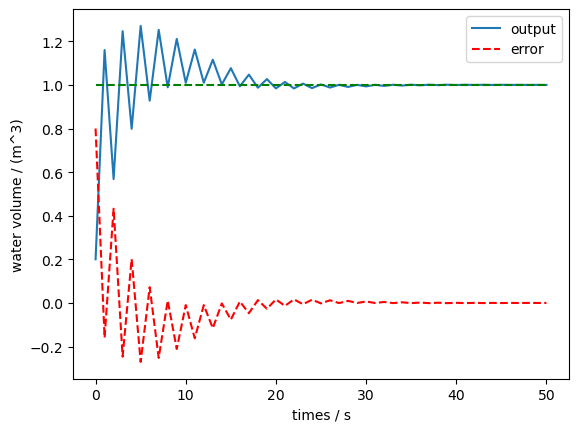

[0.2, 1.16, 0.5680000000000001, 1.2464, 0.7987200000000001, 1.270656, 0.9277888000000001, 1.25245824, 0.9890251520000001, 1.2112676096, 1.00985675008, 1.162357635584, 1.0100252677632, 1.11575650907136, 1.002208313340928, 1.0767810463647745, 0.9935167509876531, 1.0472351452409079, 0.9871812140652187, 1.0266995223282187, 0.9840453805636833, 1.0136172416415685, 0.9837058463109019, 1.0060695178596095, 0.9852793617203778, 1.0022486440914877, 0.9878527577616889, 1.0006886400411659, 0.9906986560112223, 1.0003293181807806, 0.9933393297277806, 1.0004827929020375, 0.995526174222608, 1.0007552965728443, 0.9971828834728786, 1.000959309845729, 0.9983422883638917, 1.0010356174993966, 0.999092509946804, 1.0009935671886858, 0.9995382402140734, 1.0008705832352565, 0.9997770944248451, 1.0007081396761115, 0.9998881278971269, 1.0005399434360724, 0.99992876047118, 1.0003880920439185, 0.9999366399033174, 1.0002637200706888, 0.9999337687625222]
[info] iterate times:  50


In [18]:
app_3 = ApplicationWithKpKiKd(kp=0.5, ki=0.1, kd=0.6)
app_3.run()

在真正的工程实践中，最难的是如果确定三个项的系数，这就需要大量的实验以及经验来决定了。通过不断的尝试和正确的思考，就能选取合适的系数，实现优良的控制器。

# 快速上手使用 PID
事实上，如果你想要 Python 快速上手 PID，你完全没必要自己写一个 PID 实现，因为已经有人把 PID 给封装好了，你只需要传入一些简单的参数，就能很好的实现 PID！这个库就是 simple-pid，你可以使用 pip install simple-pid 来安装该库，现在我们借由 simple-pid 中的 example 来快速上手一次。

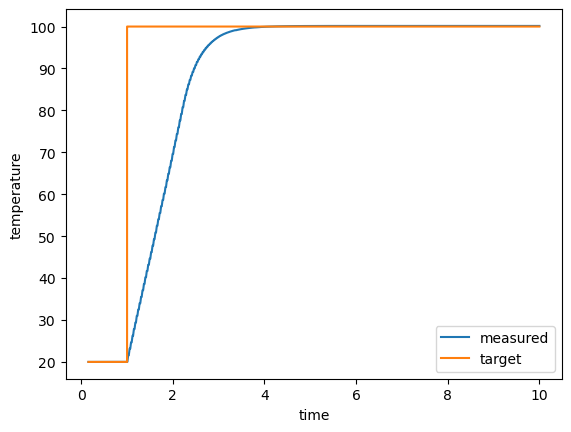

In [20]:
!pip install simple-pid

import os
import sys
import time
import matplotlib.pyplot as plt
from simple_pid import PID


class WaterBoiler:
    """
    Simple simulation of a water boiler which can heat up water
    and where the heat dissipates slowly over time
    """

    def __init__(self):
        self.water_temp = 20

    def update(self, boiler_power, dt):
        if boiler_power > 0:
            # Boiler can only produce heat, not cold
            self.water_temp += 1 * boiler_power * dt

        # Some heat dissipation
        self.water_temp -= 0.02 * dt
        return self.water_temp


if __name__ == '__main__':
    boiler = WaterBoiler()
    water_temp = boiler.water_temp

    pid = PID(5, 0.01, 0.1, setpoint=water_temp)
    pid.output_limits = (0, 100)

    start_time = time.time()
    last_time = start_time

    # Keep track of values for plotting
    setpoint, y, x = [], [], []

    while time.time() - start_time < 10:
        current_time = time.time()
        dt = current_time - last_time

        power = pid(water_temp)
        water_temp = boiler.update(power, dt)

        x += [current_time - start_time]
        y += [water_temp]
        setpoint += [pid.setpoint]

        if current_time - start_time > 1:
            pid.setpoint = 100

        last_time = current_time

    plt.plot(x, y, label='measured')
    plt.plot(x, setpoint, label='target')
    plt.xlabel('time')
    plt.ylabel('temperature')
    plt.legend()
    if os.getenv('NO_DISPLAY'):
        # If run in CI the plot is saved to file instead of shown to the user
        plt.savefig(f"result-py{'.'.join([str(x) for x in sys.version_info[:2]])}.png")
    else:
        plt.show()

这里我想说一下，为什么和 simple-pid 相比，笔者上面绘制的曲线更折更生硬一点，主要的原因是迭代次数的问题，笔者在迭代的时候只迭代了几十次，但是在一些实际问题上，PID 算法需要基于时间去做积分，而不仅仅只是做离散的迭代，因此你在 simple-pid 的 example 中也可以看到，他的迭代是通过 time 的积分微分来构建的。

# 最后附上一些关于 PID 的其他观点：

- 如果一个系统的机理模型建立的比较准确，PID 控制也是有严格的数学依据的，可以通过严格的传递函数的闭环零极点分析得到；
微分的微分为什么一般不用呢？因为微分能够严重放大噪声信号，而实际测得的输出量肯定含有噪声，因此高次微分很难用；
一般由于 PID 控制只关心输入输出，而一般不关心系统的内部特性，所以对于建模不准确的系统 PID 是最理想的控制器之一，这也导致了 PID 控制器的参数一般采用经验法来整定。

- 我喜欢这样理解 pid: p 是控制现在，i 是纠正曾经，d 是管控未来！只有不忘过往，把握当前，规划未来才能让人生的轨迹按照既定的目标前进。讲真，理解了弹性阻尼系统，对 pid 的内涵会更加深刻。

- 那为啥不加入更进一步的，微分的微分或者微分的微分的微分呢。如果有其他因素，该如何使用 PID 呢 ——@ 荆慢慢 2.0

- 一般来说微分环节相当于放大了反馈信号中的高频分量，如果取得系数不好会引起高频震荡。所以大部分应用都只采用 PI（不影响稳态精度）或者双闭环 PI。至于微分的微分等一些量在物理上并没有实际意义，比如调速中转速的微分是加速度，再次微分就基本不用了。当然如果学过自控理论则可以从系统传递函数来分析需要加入什么样的控制器来保持系统稳定收敛。—— @Lyn

# 牛顿法调参

t=1 | add 0.90000 => Tn=1.00000 error=-0.00000 | d_error: 0.00000
t=2 | add 0.10000 => Tn=1.00000 error=0.00000 | d_error: -0.80000
t=3 | add 0.10000 => Tn=1.00000 error=0.00000 | d_error: 0.00000
t=4 | add 0.10000 => Tn=1.00000 error=0.00000 | d_error: -0.00000
t=5 | add 0.10000 => Tn=1.00000 error=0.00000 | d_error: -0.00000
t=6 | add 0.10000 => Tn=1.00000 error=0.00000 | d_error: -0.00000
t=7 | add 0.10000 => Tn=1.00000 error=0.00000 | d_error: -0.00000
t=8 | add 0.10000 => Tn=1.00000 error=0.00000 | d_error: -0.00000
t=9 | add 0.10000 => Tn=1.00000 error=0.00000 | d_error: -0.00000
t=10 | add 0.10000 => Tn=1.00000 error=0.00000 | d_error: -0.00000
t=11 | add 0.10000 => Tn=1.00000 error=0.00000 | d_error: -0.00000
t=12 | add 0.10000 => Tn=1.00000 error=0.00000 | d_error: -0.00000
t=13 | add 0.10000 => Tn=1.00000 error=0.00000 | d_error: -0.00000
t=14 | add 0.10000 => Tn=1.00000 error=0.00000 | d_error: -0.00000
t=15 | add 0.10000 => Tn=1.00000 error=0.00000 | d_error: -0.00000
t=16 

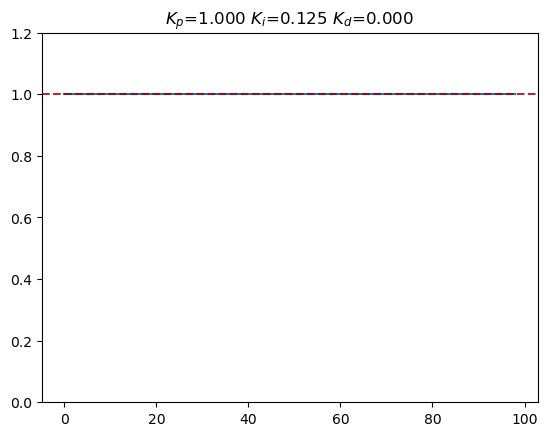

t=1 | add 0.56000 => Tn=0.66000 error=0.34000 | d_error: 0.00000
t=2 | add 0.04800 => Tn=0.60800 error=0.39200 | d_error: -0.46000
t=3 | add 0.35740 => Tn=0.86540 error=0.13460 | d_error: 0.05200
t=4 | add 0.04212 => Tn=0.80752 error=0.19248 | d_error: -0.25740
t=5 | add 0.24701 => Tn=0.95453 error=0.04547 | d_error: 0.05788
t=6 | add 0.05128 => Tn=0.90581 error=0.09419 | d_error: -0.14701
t=7 | add 0.18552 => Tn=0.99133 error=0.00867 | d_error: 0.04872
t=8 | add 0.06325 => Tn=0.95458 error=0.04542 | d_error: -0.08552
t=9 | add 0.15054 => Tn=1.00512 error=-0.00512 | d_error: 0.03675
t=10 | add 0.07379 => Tn=0.97891 error=0.02109 | d_error: -0.05054
t=11 | add 0.13026 => Tn=1.00916 error=-0.00916 | d_error: 0.02621
t=12 | add 0.08190 => Tn=0.99106 error=0.00894 | d_error: -0.03026
t=13 | add 0.11829 => Tn=1.00935 error=-0.00935 | d_error: 0.01810
t=14 | add 0.08774 => Tn=0.99709 error=0.00291 | d_error: -0.01829
t=15 | add 0.11113 => Tn=1.00822 error=-0.00822 | d_error: 0.01226
t=16 | a

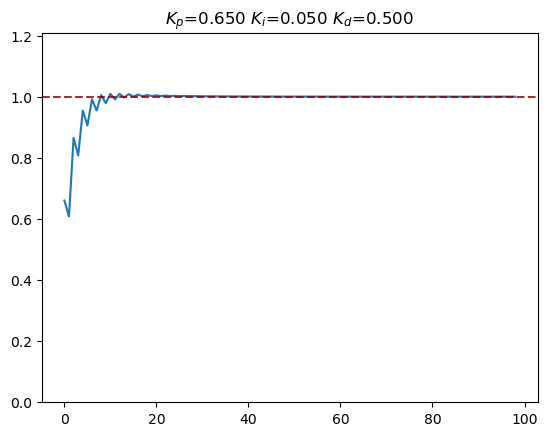

0.05847053461803351

In [1]:
from scipy import optimize 
import matplotlib.pyplot as plt
import numpy as np

def pid_plot(args, plot_flag=True, print_flag=False):
    kp, ki, kd = args
    T=1
    Tn=0.2
    error=1-0.2
    extra_drop = 0.1
    sum_error = 0
    d_error = 0
    error_n = 0
    error_b = 0
    Tn_list = []
    for t in range(1, 100):
        error_b = error_n
        error_n = error
        d_error = error_n - error_b if t >= 2 else 0
        sum_error += error
        U = kp * error + ki * sum_error + kd * d_error
        Tn += U - extra_drop
        error = T-Tn
        Tn_list.append(Tn)
        if print_flag:
            print(f't={t} | add {U:.5f} => Tn={Tn:.5f} error={error:.5f} | d_error: {d_error:.5f}')

    if plot_flag:
        plt.plot(Tn_list)
        plt.axhline(1, linestyle='--', color='darkred', alpha=0.8)
        plt.title(f'$K_p$={kp:.3f} $K_i$={ki:.3f} $K_d$={kd:.3f}')
        plt.ylim([0, max(Tn_list) + 0.2])
        plt.show()

    loss = np.sqrt(np.mean(np.square(np.ones_like(Tn_list) - np.array(Tn_list))))
    return loss



boundaries=[(0, 2), (0, 2), (0, 2)]
res = optimize.fmin_l_bfgs_b(pid_plot, np.array([0.1, 0.1, 0.1]), args=(False, False), bounds = boundaries, approx_grad = True)

pid_plot(res[0].tolist(), print_flag=True)
pid_plot([0.65, 0.05, 0.5], print_flag=True)

t=1 | add 0.90000 => Tn=1.00000 error=-0.00000 | d_error: 0.00000
t=2 | add 0.10000 => Tn=1.00000 error=0.00000 | d_error: -0.80000
t=3 | add 0.10000 => Tn=1.00000 error=0.00000 | d_error: 0.00000
t=4 | add 0.10000 => Tn=1.00000 error=0.00000 | d_error: -0.00000
t=5 | add 0.10000 => Tn=1.00000 error=0.00000 | d_error: -0.00000
t=6 | add 0.10000 => Tn=1.00000 error=0.00000 | d_error: -0.00000
t=7 | add 0.10000 => Tn=1.00000 error=0.00000 | d_error: -0.00000
t=8 | add 0.10000 => Tn=1.00000 error=0.00000 | d_error: -0.00000
t=9 | add 0.10000 => Tn=1.00000 error=0.00000 | d_error: -0.00000
t=10 | add 0.10000 => Tn=1.00000 error=0.00000 | d_error: -0.00000
t=11 | add 0.10000 => Tn=1.00000 error=0.00000 | d_error: -0.00000
t=12 | add 0.10000 => Tn=1.00000 error=0.00000 | d_error: -0.00000
t=13 | add 0.10000 => Tn=1.00000 error=0.00000 | d_error: -0.00000
t=14 | add 0.10000 => Tn=1.00000 error=0.00000 | d_error: -0.00000
t=15 | add 0.10000 => Tn=1.00000 error=0.00000 | d_error: -0.00000
t=16 

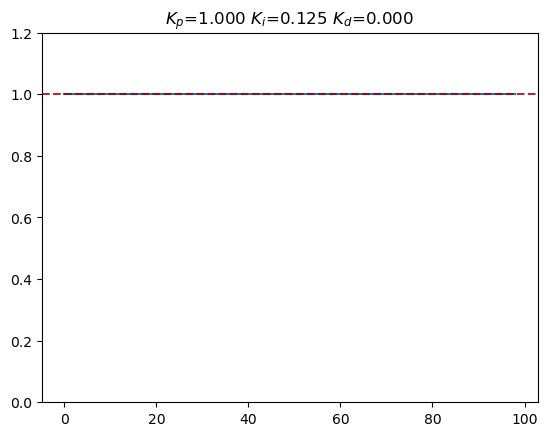

t=1 | add 0.56000 => Tn=0.66000 error=0.34000 | d_error: 0.00000
t=2 | add 0.04800 => Tn=0.60800 error=0.39200 | d_error: -0.46000
t=3 | add 0.35740 => Tn=0.86540 error=0.13460 | d_error: 0.05200
t=4 | add 0.04212 => Tn=0.80752 error=0.19248 | d_error: -0.25740
t=5 | add 0.24701 => Tn=0.95453 error=0.04547 | d_error: 0.05788
t=6 | add 0.05128 => Tn=0.90581 error=0.09419 | d_error: -0.14701
t=7 | add 0.18552 => Tn=0.99133 error=0.00867 | d_error: 0.04872
t=8 | add 0.06325 => Tn=0.95458 error=0.04542 | d_error: -0.08552
t=9 | add 0.15054 => Tn=1.00512 error=-0.00512 | d_error: 0.03675
t=10 | add 0.07379 => Tn=0.97891 error=0.02109 | d_error: -0.05054
t=11 | add 0.13026 => Tn=1.00916 error=-0.00916 | d_error: 0.02621
t=12 | add 0.08190 => Tn=0.99106 error=0.00894 | d_error: -0.03026
t=13 | add 0.11829 => Tn=1.00935 error=-0.00935 | d_error: 0.01810
t=14 | add 0.08774 => Tn=0.99709 error=0.00291 | d_error: -0.01829
t=15 | add 0.11113 => Tn=1.00822 error=-0.00822 | d_error: 0.01226
t=16 | a

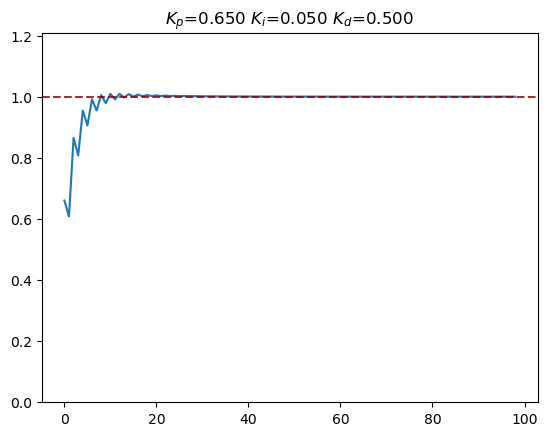

0.05847053461803351

In [ ]:
from scipy import optimize 
import matplotlib.pyplot as plt
import numpy as np

def pid_plot(args, plot_flag=True, print_flag=False):
    kp, ki, kd = args
    T=1
    Tn=0.2
    error=1-0.2
    extra_drop = 0.1
    sum_error = 0
    d_error = 0
    error_n = 0
    error_b = 0
    Tn_list = []
    for t in range(1, 100):
        error_b = error_n
        error_n = error
        d_error = error_n - error_b if t >= 2 else 0
        sum_error += error
        U = kp * error + ki * sum_error + kd * d_error
        Tn += U - extra_drop
        error = T-Tn
        Tn_list.append(Tn)
        if print_flag:
            print(f't={t} | add {U:.5f} => Tn={Tn:.5f} error={error:.5f} | d_error: {d_error:.5f}')

    if plot_flag:
        plt.plot(Tn_list)
        plt.axhline(1, linestyle='--', color='darkred', alpha=0.8)
        plt.title(f'$K_p$={kp:.3f} $K_i$={ki:.3f} $K_d$={kd:.3f}')
        plt.ylim([0, max(Tn_list) + 0.2])
        plt.show()

    loss = np.sqrt(np.mean(np.square(np.ones_like(Tn_list) - np.array(Tn_list))))
    return loss



boundaries=[(0, 2), (0, 2), (0, 2)]
res = optimize.fmin_l_bfgs_b(pid_plot, np.array([0.1, 0.1, 0.1]), args=(False, False), bounds = boundaries, approx_grad = True)

pid_plot(res[0].tolist(), print_flag=True)
pid_plot([0.65, 0.05, 0.5], print_flag=True)

t=1 | add 0.90000 => Tn=1.00000 error=-0.00000 | d_error: 0.00000
t=2 | add 0.10000 => Tn=1.00000 error=0.00000 | d_error: -0.80000
t=3 | add 0.10000 => Tn=1.00000 error=0.00000 | d_error: 0.00000
t=4 | add 0.10000 => Tn=1.00000 error=0.00000 | d_error: -0.00000
t=5 | add 0.10000 => Tn=1.00000 error=0.00000 | d_error: -0.00000
t=6 | add 0.10000 => Tn=1.00000 error=0.00000 | d_error: -0.00000
t=7 | add 0.10000 => Tn=1.00000 error=0.00000 | d_error: -0.00000
t=8 | add 0.10000 => Tn=1.00000 error=0.00000 | d_error: -0.00000
t=9 | add 0.10000 => Tn=1.00000 error=0.00000 | d_error: -0.00000
t=10 | add 0.10000 => Tn=1.00000 error=0.00000 | d_error: -0.00000
t=11 | add 0.10000 => Tn=1.00000 error=0.00000 | d_error: -0.00000
t=12 | add 0.10000 => Tn=1.00000 error=0.00000 | d_error: -0.00000
t=13 | add 0.10000 => Tn=1.00000 error=0.00000 | d_error: -0.00000
t=14 | add 0.10000 => Tn=1.00000 error=0.00000 | d_error: -0.00000
t=15 | add 0.10000 => Tn=1.00000 error=0.00000 | d_error: -0.00000
t=16 

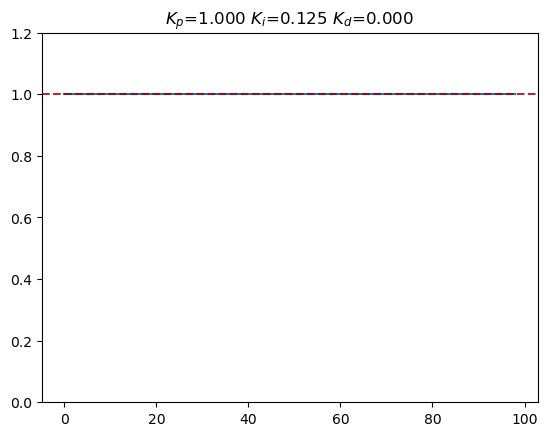

t=1 | add 0.56000 => Tn=0.66000 error=0.34000 | d_error: 0.00000
t=2 | add 0.04800 => Tn=0.60800 error=0.39200 | d_error: -0.46000
t=3 | add 0.35740 => Tn=0.86540 error=0.13460 | d_error: 0.05200
t=4 | add 0.04212 => Tn=0.80752 error=0.19248 | d_error: -0.25740
t=5 | add 0.24701 => Tn=0.95453 error=0.04547 | d_error: 0.05788
t=6 | add 0.05128 => Tn=0.90581 error=0.09419 | d_error: -0.14701
t=7 | add 0.18552 => Tn=0.99133 error=0.00867 | d_error: 0.04872
t=8 | add 0.06325 => Tn=0.95458 error=0.04542 | d_error: -0.08552
t=9 | add 0.15054 => Tn=1.00512 error=-0.00512 | d_error: 0.03675
t=10 | add 0.07379 => Tn=0.97891 error=0.02109 | d_error: -0.05054
t=11 | add 0.13026 => Tn=1.00916 error=-0.00916 | d_error: 0.02621
t=12 | add 0.08190 => Tn=0.99106 error=0.00894 | d_error: -0.03026
t=13 | add 0.11829 => Tn=1.00935 error=-0.00935 | d_error: 0.01810
t=14 | add 0.08774 => Tn=0.99709 error=0.00291 | d_error: -0.01829
t=15 | add 0.11113 => Tn=1.00822 error=-0.00822 | d_error: 0.01226
t=16 | a

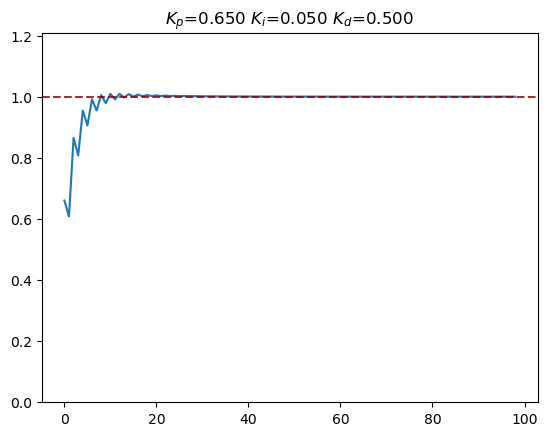

0.05847053461803351

In [ ]:
from scipy import optimize 
import matplotlib.pyplot as plt
import numpy as np

def pid_plot(args, plot_flag=True, print_flag=False):
    kp, ki, kd = args
    T=1
    Tn=0.2
    error=1-0.2
    extra_drop = 0.1
    sum_error = 0
    d_error = 0
    error_n = 0
    error_b = 0
    Tn_list = []
    for t in range(1, 100):
        error_b = error_n
        error_n = error
        d_error = error_n - error_b if t >= 2 else 0
        sum_error += error
        U = kp * error + ki * sum_error + kd * d_error
        Tn += U - extra_drop
        error = T-Tn
        Tn_list.append(Tn)
        if print_flag:
            print(f't={t} | add {U:.5f} => Tn={Tn:.5f} error={error:.5f} | d_error: {d_error:.5f}')

    if plot_flag:
        plt.plot(Tn_list)
        plt.axhline(1, linestyle='--', color='darkred', alpha=0.8)
        plt.title(f'$K_p$={kp:.3f} $K_i$={ki:.3f} $K_d$={kd:.3f}')
        plt.ylim([0, max(Tn_list) + 0.2])
        plt.show()

    loss = np.sqrt(np.mean(np.square(np.ones_like(Tn_list) - np.array(Tn_list))))
    return loss



boundaries=[(0, 2), (0, 2), (0, 2)]
res = optimize.fmin_l_bfgs_b(pid_plot, np.array([0.1, 0.1, 0.1]), args=(False, False), bounds = boundaries, approx_grad = True)

pid_plot(res[0].tolist(), print_flag=True)
pid_plot([0.65, 0.05, 0.5], print_flag=True)